In [1]:
from brainlit.map_neurons.diffeo_gen import expR
import numpy as np 
import matplotlib.pyplot as plt
import torch

<matplotlib.contour.QuadContourSet object at 0x1572b6c40>

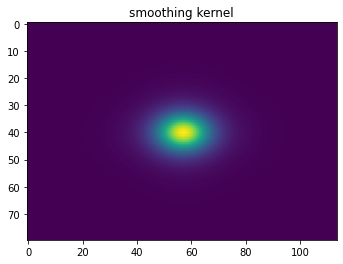

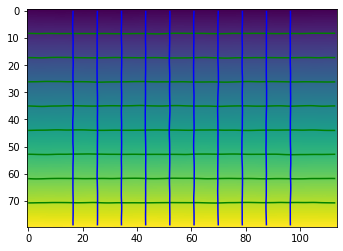

In [2]:
ara_10_size = [1320, 800, 1410]
spacing = 100.0

# a domain for sampling your velocity and deformatoin
dv = np.array([spacing]*3)
nv = np.array([132,80,114])
xv = [np.arange(n)*d - (n-1)*d/2 for n,d in zip(nv,dv)]
levels = np.linspace(-40*int(spacing),40*int(spacing),10)


XV = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xv],indexing='ij'),-1)

# a frequency domain
fv = [np.arange(n)/n/d for n,d in zip(nv,dv)]
FV = np.stack(np.meshgrid(*fv,indexing='ij'),-1)
a = spacing
p = 2.0
LL = (1.0 - 2.0*a**2*np.sum(((np.cos(2.0*np.pi*FV*dv)   - 1))/dv**2,-1))**(2*p)
K = 1.0/LL
fig,ax = plt.subplots()
ax.imshow(np.fft.ifftshift(K[0]))
ax.set_title('smoothing kernel')


# lets make a new p which is really simple for testing
# sample white noise
Lm = np.random.randn(*FV.shape)*200

# smooth it with sqrt(K) (here I smoothed with K to be a bit smoother)
v = np.fft.ifftn(np.fft.fftn(Lm,axes=(0,1,2))*K[...,None],axes=(0,1,2)).real

#shoot it with remannian exponential
phii = expR([torch.tensor(x) for x in xv],torch.tensor(v),K,n=10)

fig,ax = plt.subplots()
ax.imshow(phii[v.shape[0]//2,...,1])
ax.contour(phii[v.shape[0]//2,...,0],levels,colors='r',linestyles='-')
ax.contour(phii[v.shape[0]//2,...,1],levels,colors='g',linestyles='-')
ax.contour(phii[v.shape[0]//2,...,2],levels,colors='b',linestyles='-')

In [3]:
print("each unit is 20 microns")

each unit is 20 microns


# Plot transform

In [4]:
from scipy.spatial.distance import cosine
from brainlit.map_neurons.map_neurons import (
    DiffeomorphismAction,
    Diffeomorphism_Transform,
    transform_geometricgraph,
    compute_derivs,
    CloudReg_Transform,
)
import pandas as pd 
import seaborn as sns
import os 
from cloudvolume import CloudVolume
from pathlib import Path
from brainlit.algorithms.trace_analysis.fit_spline import (
    GeometricGraph,
    compute_parameterization,
    CubicHermiteChain,
)
from brainlit.utils.Neuron_trace import NeuronTrace
from copy import deepcopy
from tqdm import tqdm
from scipy.interpolate import splev, splprep, CubicHermiteSpline

In [5]:
phii = phii.detach().cpu().numpy()

root_dir = Path(os.path.abspath(""))
data_dir = os.path.join(root_dir, "data", "mapping-files")

In [6]:
ct = Diffeomorphism_Transform(xv, phii)


average squared deformation 105.47137499277429
average 1-cosine between derivatives 0.0003888746821060704


<matplotlib.legend.Legend object at 0x157b7be50>

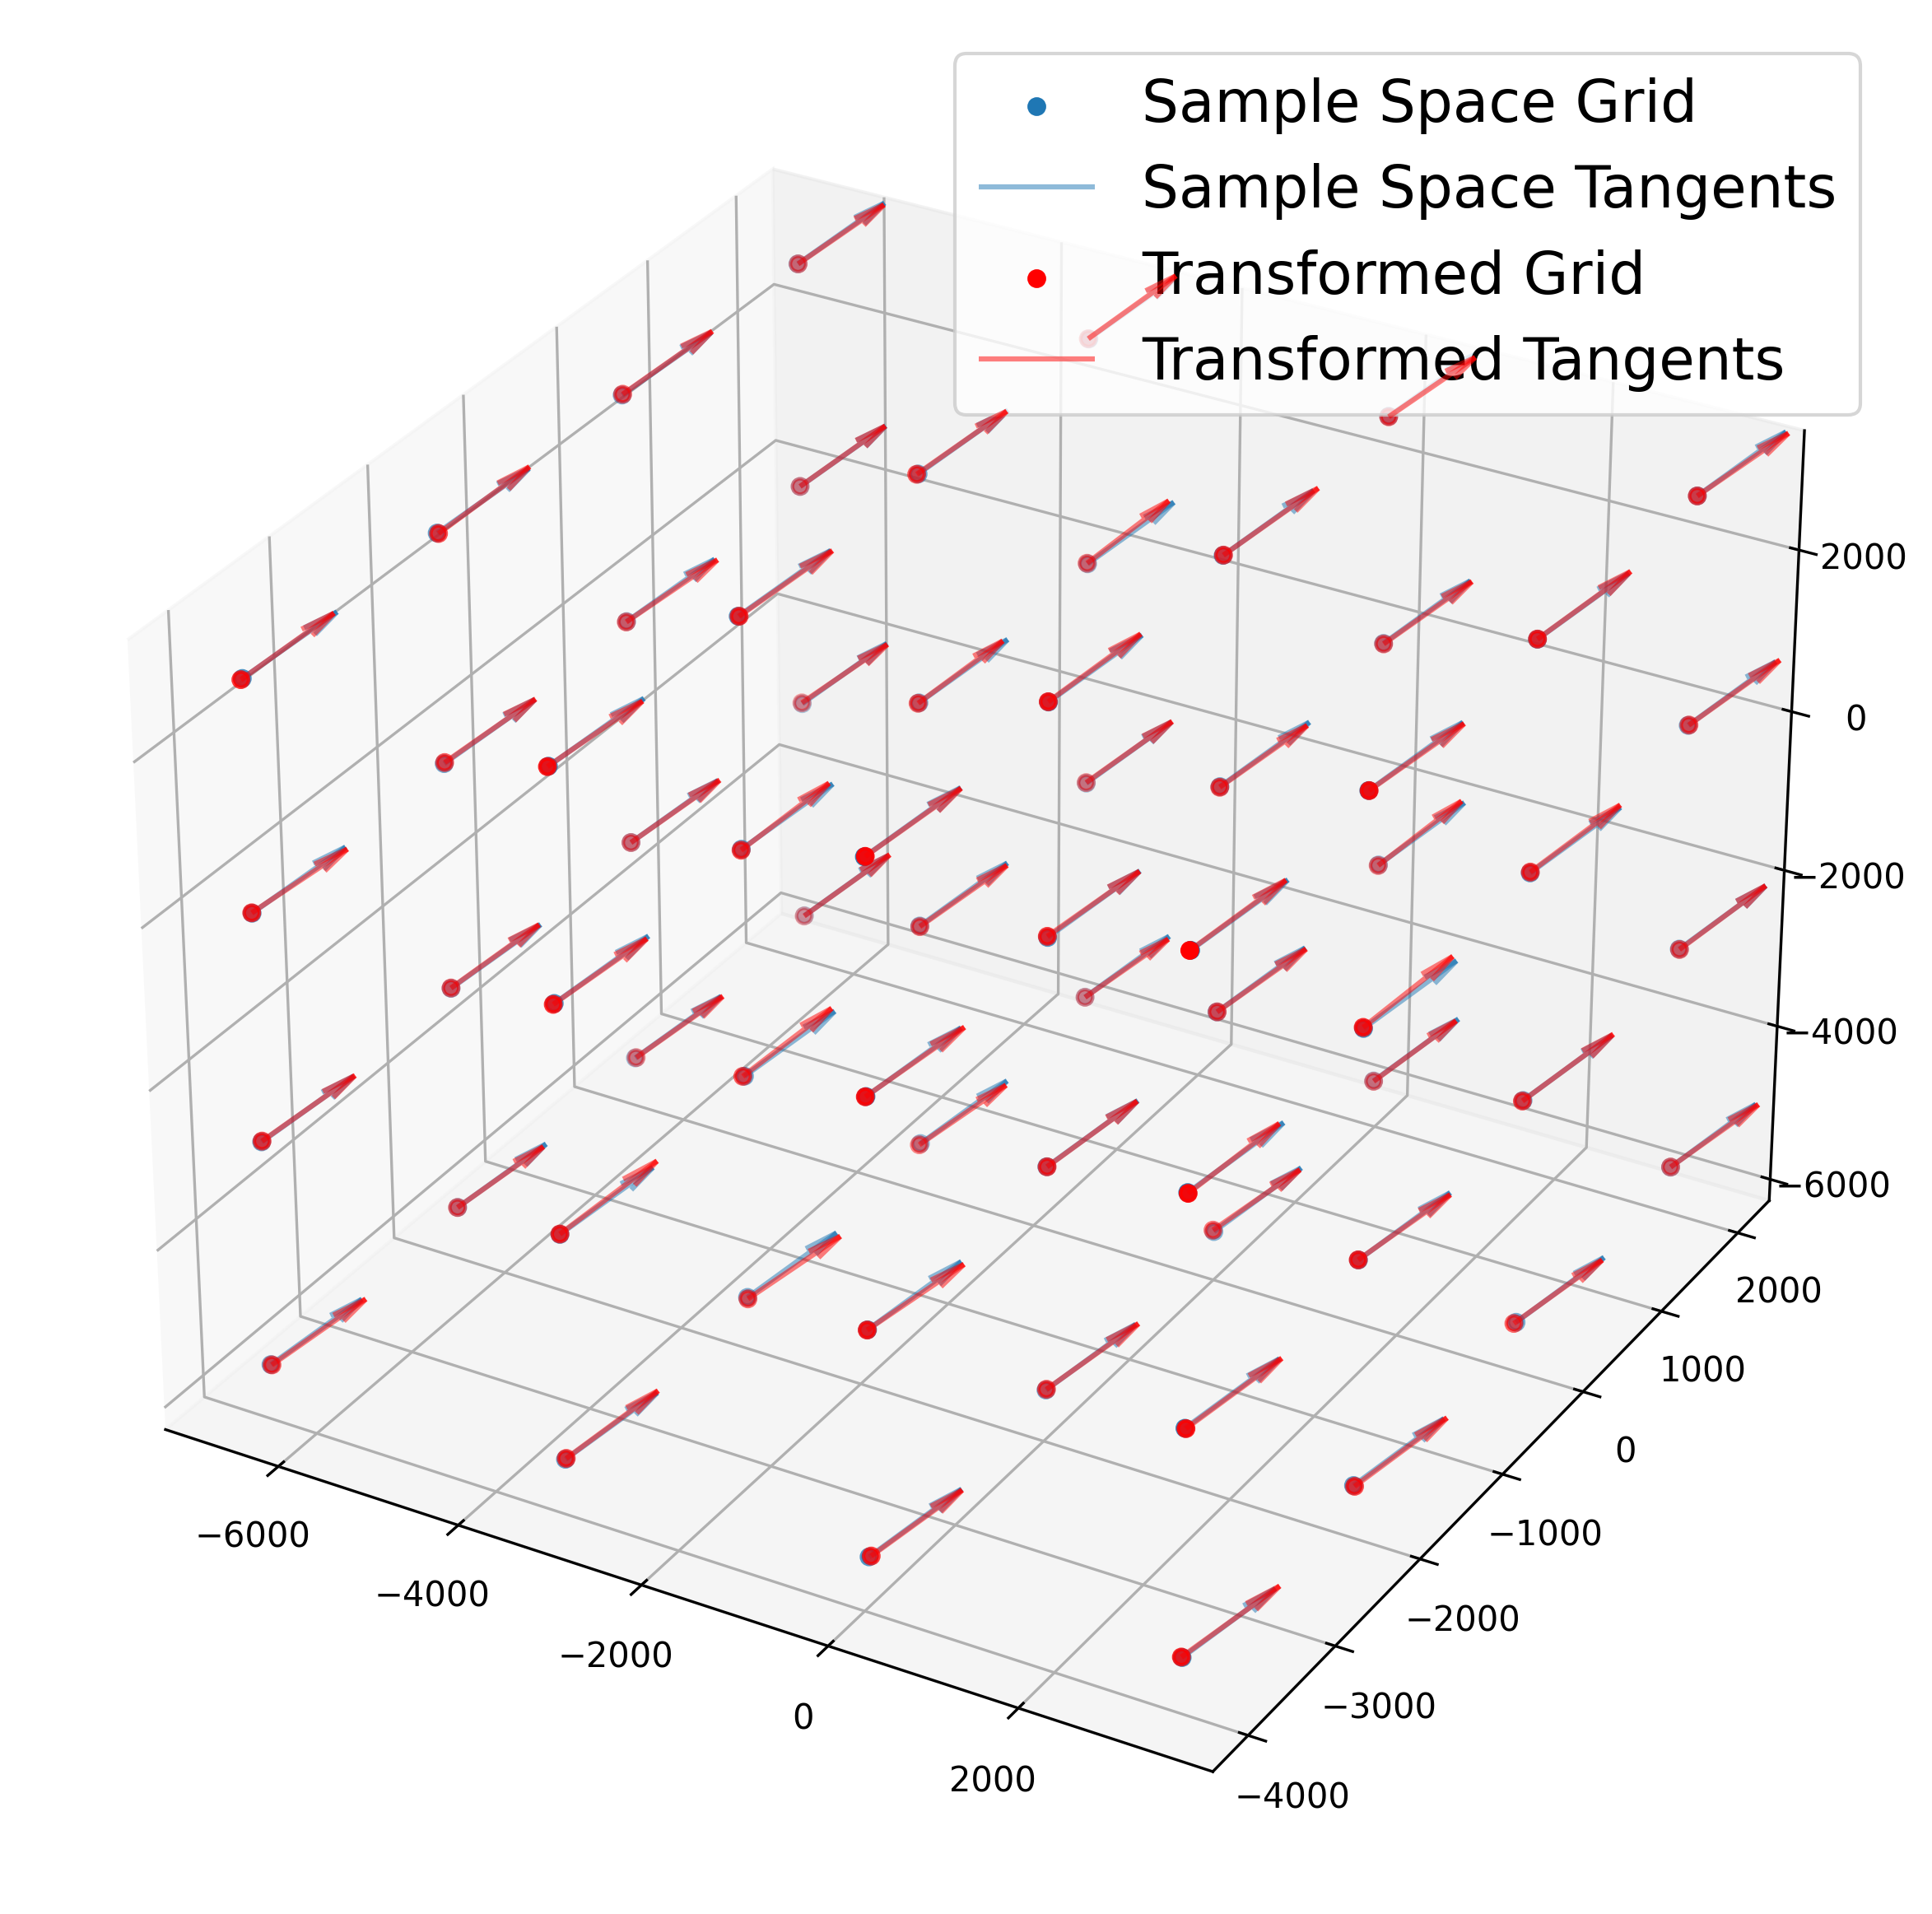

In [7]:
vlen = 500
og_coords = ct.og_coords

xmin = np.amin(og_coords[0])
xmax = np.amax(og_coords[0])
ymin = np.amin(og_coords[1])
ymax = np.amax(og_coords[1])
zmin = np.amin(og_coords[2])
zmax = np.amax(og_coords[2])

xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T

fig = plt.figure(figsize=(10, 10), dpi=300)
ax = fig.add_subplot(projection='3d')

ax.scatter3D(
    og_coords[:, 0], og_coords[:, 1], og_coords[:, 2], label="Sample Space Grid"
)

ax.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    np.ones((og_coords.shape[0])),
    np.ones((og_coords.shape[0])),
    np.ones((og_coords.shape[0])),
    length=vlen,
    label="Sample Space Tangents",
    alpha=0.5,
)

new_coords = ct.evaluate(og_coords)
print(
    f"average squared deformation {np.sum((og_coords-new_coords)**2)/og_coords.shape[0]}"
)
new_derivs = ct.D(og_coords, np.ones(og_coords.shape))
cosines = []
for new_deriv in new_derivs:
    sn = cosine(new_deriv, [1, 1, 1])
    cosines.append(sn)
print(f"average 1-cosine between derivatives {np.mean(cosines)}")

ax.scatter3D(
    new_coords[:, 0],
    new_coords[:, 1],
    new_coords[:, 2],
    label="Transformed Grid",
    color="red",
)
ax.quiver(
    new_coords[:, 0],
    new_coords[:, 1],
    new_coords[:, 2],
    new_derivs[:, 0],
    new_derivs[:, 1],
    new_derivs[:, 2],
    length=vlen,
    color="red",
    label="Transformed Tangents",
    alpha=0.5,
)
# ax.quiver(og_coords[:,0],og_coords[:,1],og_coords[:,2], new_coords[:,0]-og_coords[:,0],new_coords[:,1]-og_coords[:,1],new_coords[:,2]-og_coords[:,2], length=20, color='blue', label="Scaled Displacement Field")
ax.legend(fontsize=17)

In [8]:
ct.Jacobian([0,0,0])

array([[ 1.01194977, -0.01177483, -0.00265777],
       [-0.01178136,  0.99846878, -0.03051962],
       [-0.02170334,  0.0028425 ,  0.99156042]])

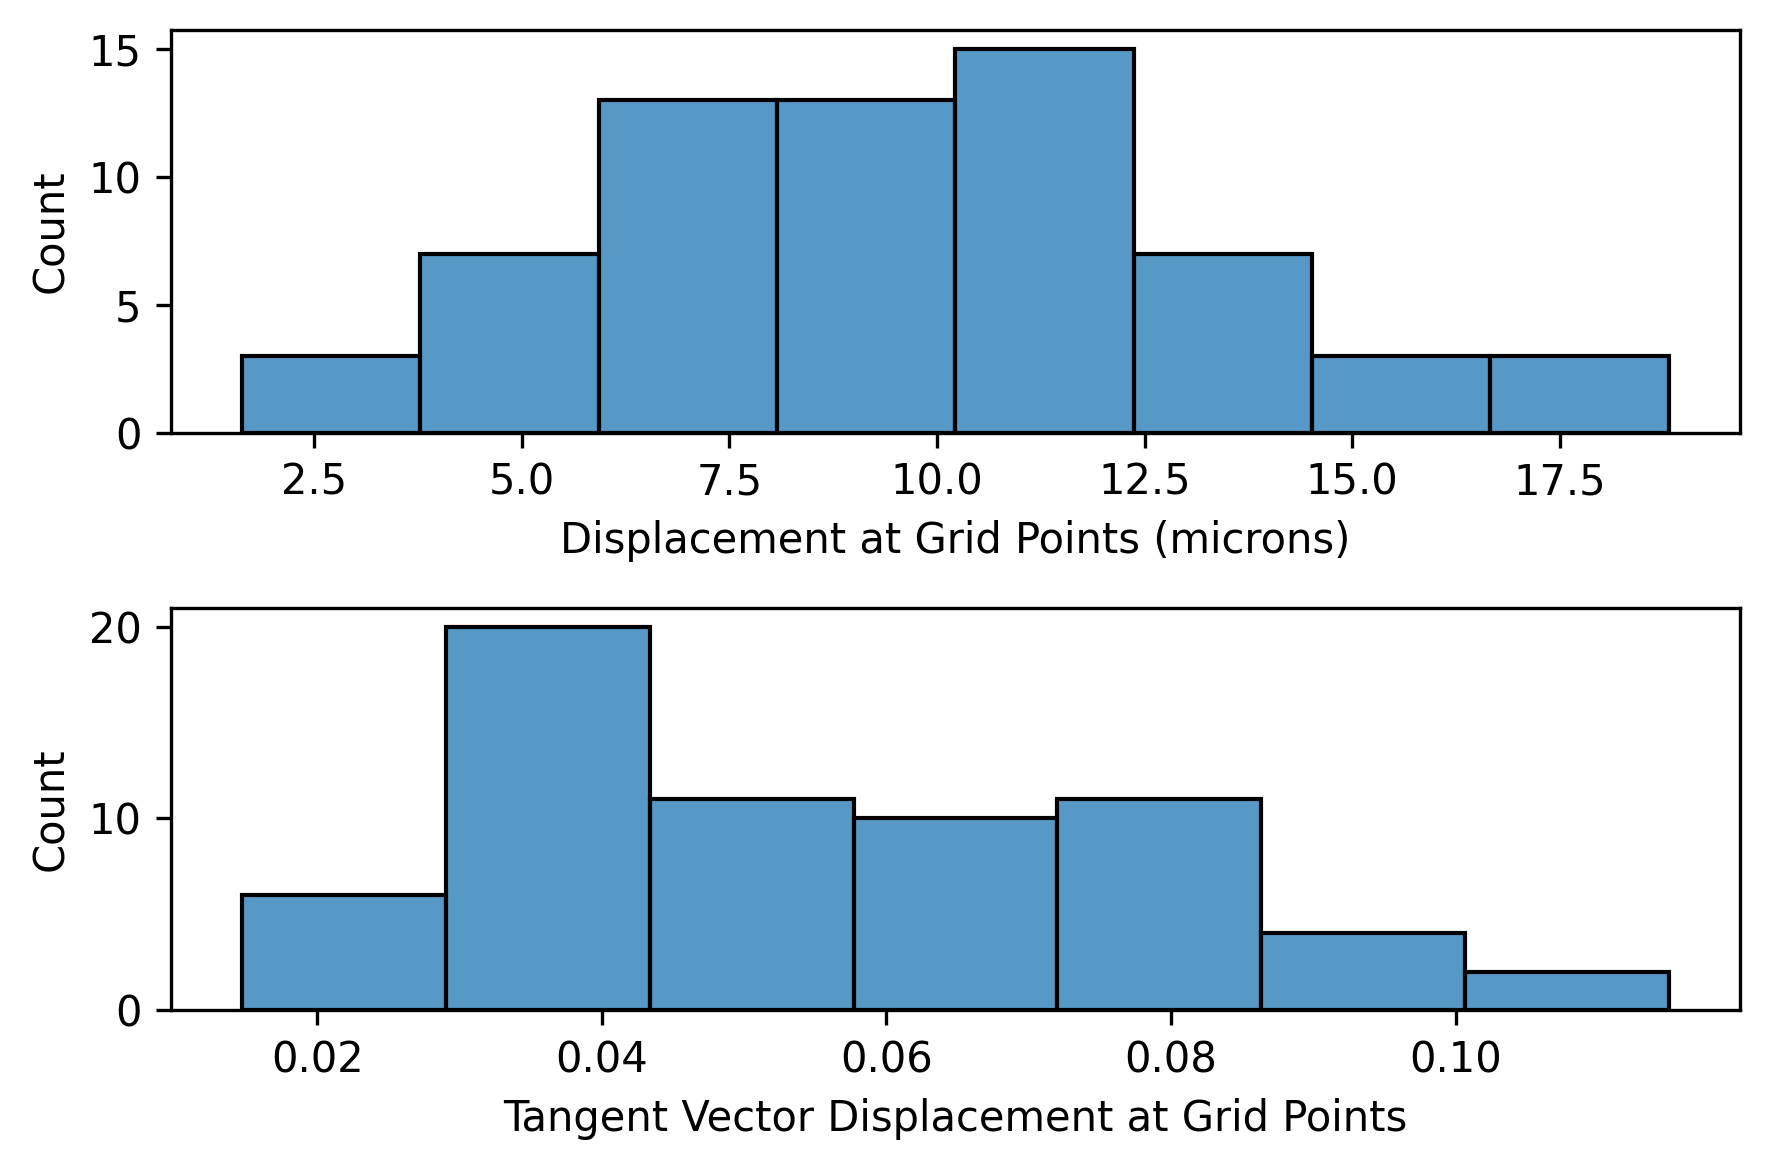

In [9]:
fig, axs = plt.subplots(2, dpi=300)
position_diff = np.linalg.norm(og_coords - new_coords, axis=1)
deriv_diff = np.linalg.norm(np.ones(og_coords.shape) - new_derivs, axis=1)
data = {
    "Displacement at Grid Points (microns)": position_diff,
    "Tangent Vector Displacement at Grid Points": deriv_diff,
}
df = pd.DataFrame(data=data)
sns.histplot(data=df, ax=axs[0], x="Displacement at Grid Points (microns)")
sns.histplot(data=df, ax=axs[1], x="Tangent Vector Displacement at Grid Points")
plt.tight_layout()

In [12]:
ntrace = NeuronTrace("/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/mouselight-swcs/AA1537.swc")

/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/brainlit/utils/Neuron_trace.py:741: UserWarning: No offset information found in: /Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/mouselight-swcs/AA1537.swc
  warnings.warn("No offset information found in: " + path)


In [21]:
g = ntrace.get_graph()
g.nodes[1]

{'x': 4332.961268, 'y': 2082.061128, 'z': 3804.889706}

In [20]:
g.edges

OutEdgeView([(1, 2), (1, 3105), (1, 3982), (1, 4003), (1, 4016), (1, 4047), (1, 4061), (1, 4096), (1, 4155), (1, 4205), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (21, 2116), (22, 23), (23, 24), (23, 2059), (24, 25), (24, 1965), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31), (31, 32), (32, 33), (33, 34), (34, 35), (35, 36), (36, 37), (37, 38), (38, 39), (39, 40), (40, 41), (41, 42), (42, 43), (43, 44), (44, 45), (45, 46), (46, 47), (47, 48), (48, 49), (49, 50), (50, 51), (51, 52), (52, 53), (53, 54), (54, 55), (55, 56), (56, 57), (57, 58), (58, 59), (59, 60), (60, 61), (61, 62), (62, 63), (63, 64), (64, 65), (65, 66), (66, 67), (67, 68), (68, 69), (69, 70), (70, 71), (71, 72), (72, 73), (73, 74), (74, 75), (74, 1962), (75, 76), (76, 77), (77, 78), (78, 79), (79, 80), (80, 81), (81, 82), (82, 83), (83, 84), (84, 85), (85, 86), (86, 87), (87, 88), (88, 89), (89, 90), (90, 91), (91, 92), (92, 93), (93, 94), (94, 95), (95, 96), (96, 97), (97, 98), (98, 99), (99, 100), (100, 101), (101, 102), (102, 103), (103, 104), (104, 105), (105, 106), (106, 107), (107, 108), (108, 109), (109, 110), (110, 111), (111, 112), (112, 113), (113, 114), (114, 115), (115, 116), (116, 117), (117, 118), (118, 119), (119, 120), (120, 121), (121, 122), (122, 123), (123, 124), (124, 125), (125, 126), (126, 127), (127, 128), (128, 129), (129, 130), (130, 131), (131, 132), (132, 133), (133, 134), (134, 135), (135, 136), (136, 137), (137, 138), (138, 139), (139, 140), (140, 141), (141, 142), (142, 143), (143, 144), (144, 145), (145, 146), (146, 147), (147, 148), (148, 149), (149, 150), (150, 151), (151, 152), (152, 153), (153, 154), (154, 155), (155, 156), (156, 157), (157, 158), (158, 159), (159, 160), (160, 161), (161, 162), (162, 163), (163, 164), (164, 165), (165, 166), (166, 167), (167, 168), (168, 169), (169, 170), (170, 171), (171, 172), (172, 173), (173, 174), (174, 175), (175, 176), (176, 177), (177, 178), (178, 179), (179, 180), (180, 181), (181, 182), (182, 183), (183, 184), (184, 185), (185, 186), (186, 187), (187, 188), (188, 189), (189, 190), (190, 191), (191, 192), (192, 193), (193, 194), (194, 195), (195, 196), (196, 197), (197, 198), (198, 199), (199, 200), (200, 201), (201, 202), (202, 203), (203, 204), (204, 205), (205, 206), (206, 207), (207, 208), (208, 209), (209, 210), (210, 211), (211, 212), (212, 213), (213, 214), (214, 215), (215, 216), (216, 217), (217, 218), (218, 219), (219, 220), (220, 221), (221, 222), (222, 223), (223, 224), (224, 225), (225, 226), (226, 227), (227, 228), (228, 229), (229, 230), (230, 231), (231, 232), (232, 233), (233, 234), (234, 235), (235, 236), (236, 237), (237, 238), (238, 239), (239, 240), (240, 241), (241, 242), (242, 243), (243, 244), (244, 245), (245, 246), (246, 247), (247, 248), (248, 249), (249, 250), (250, 251), (251, 252), (252, 253), (253, 254), (254, 255), (255, 256), (256, 257), (257, 258), (258, 259), (259, 260), (260, 261), (261, 262), (262, 263), (263, 264), (264, 265), (265, 266), (266, 267), (267, 268), (268, 269), (269, 270), (270, 271), (271, 272), (272, 273), (273, 274), (274, 275), (275, 276), (276, 277), (277, 278), (278, 279), (279, 280), (280, 281), (281, 282), (282, 283), (283, 284), (284, 285), (285, 286), (286, 287), (287, 288), (288, 289), (289, 290), (290, 291), (291, 292), (292, 293), (293, 294), (294, 295), (295, 296), (296, 297), (297, 298), (298, 299), (299, 300), (300, 301), (301, 302), (302, 303), (303, 304), (304, 305), (305, 306), (306, 307), (307, 308), (308, 309), (309, 310), (310, 311), (311, 3

Target space: 100%|██████████| 183/183 [00:00<00:00, 127713.42it/s]


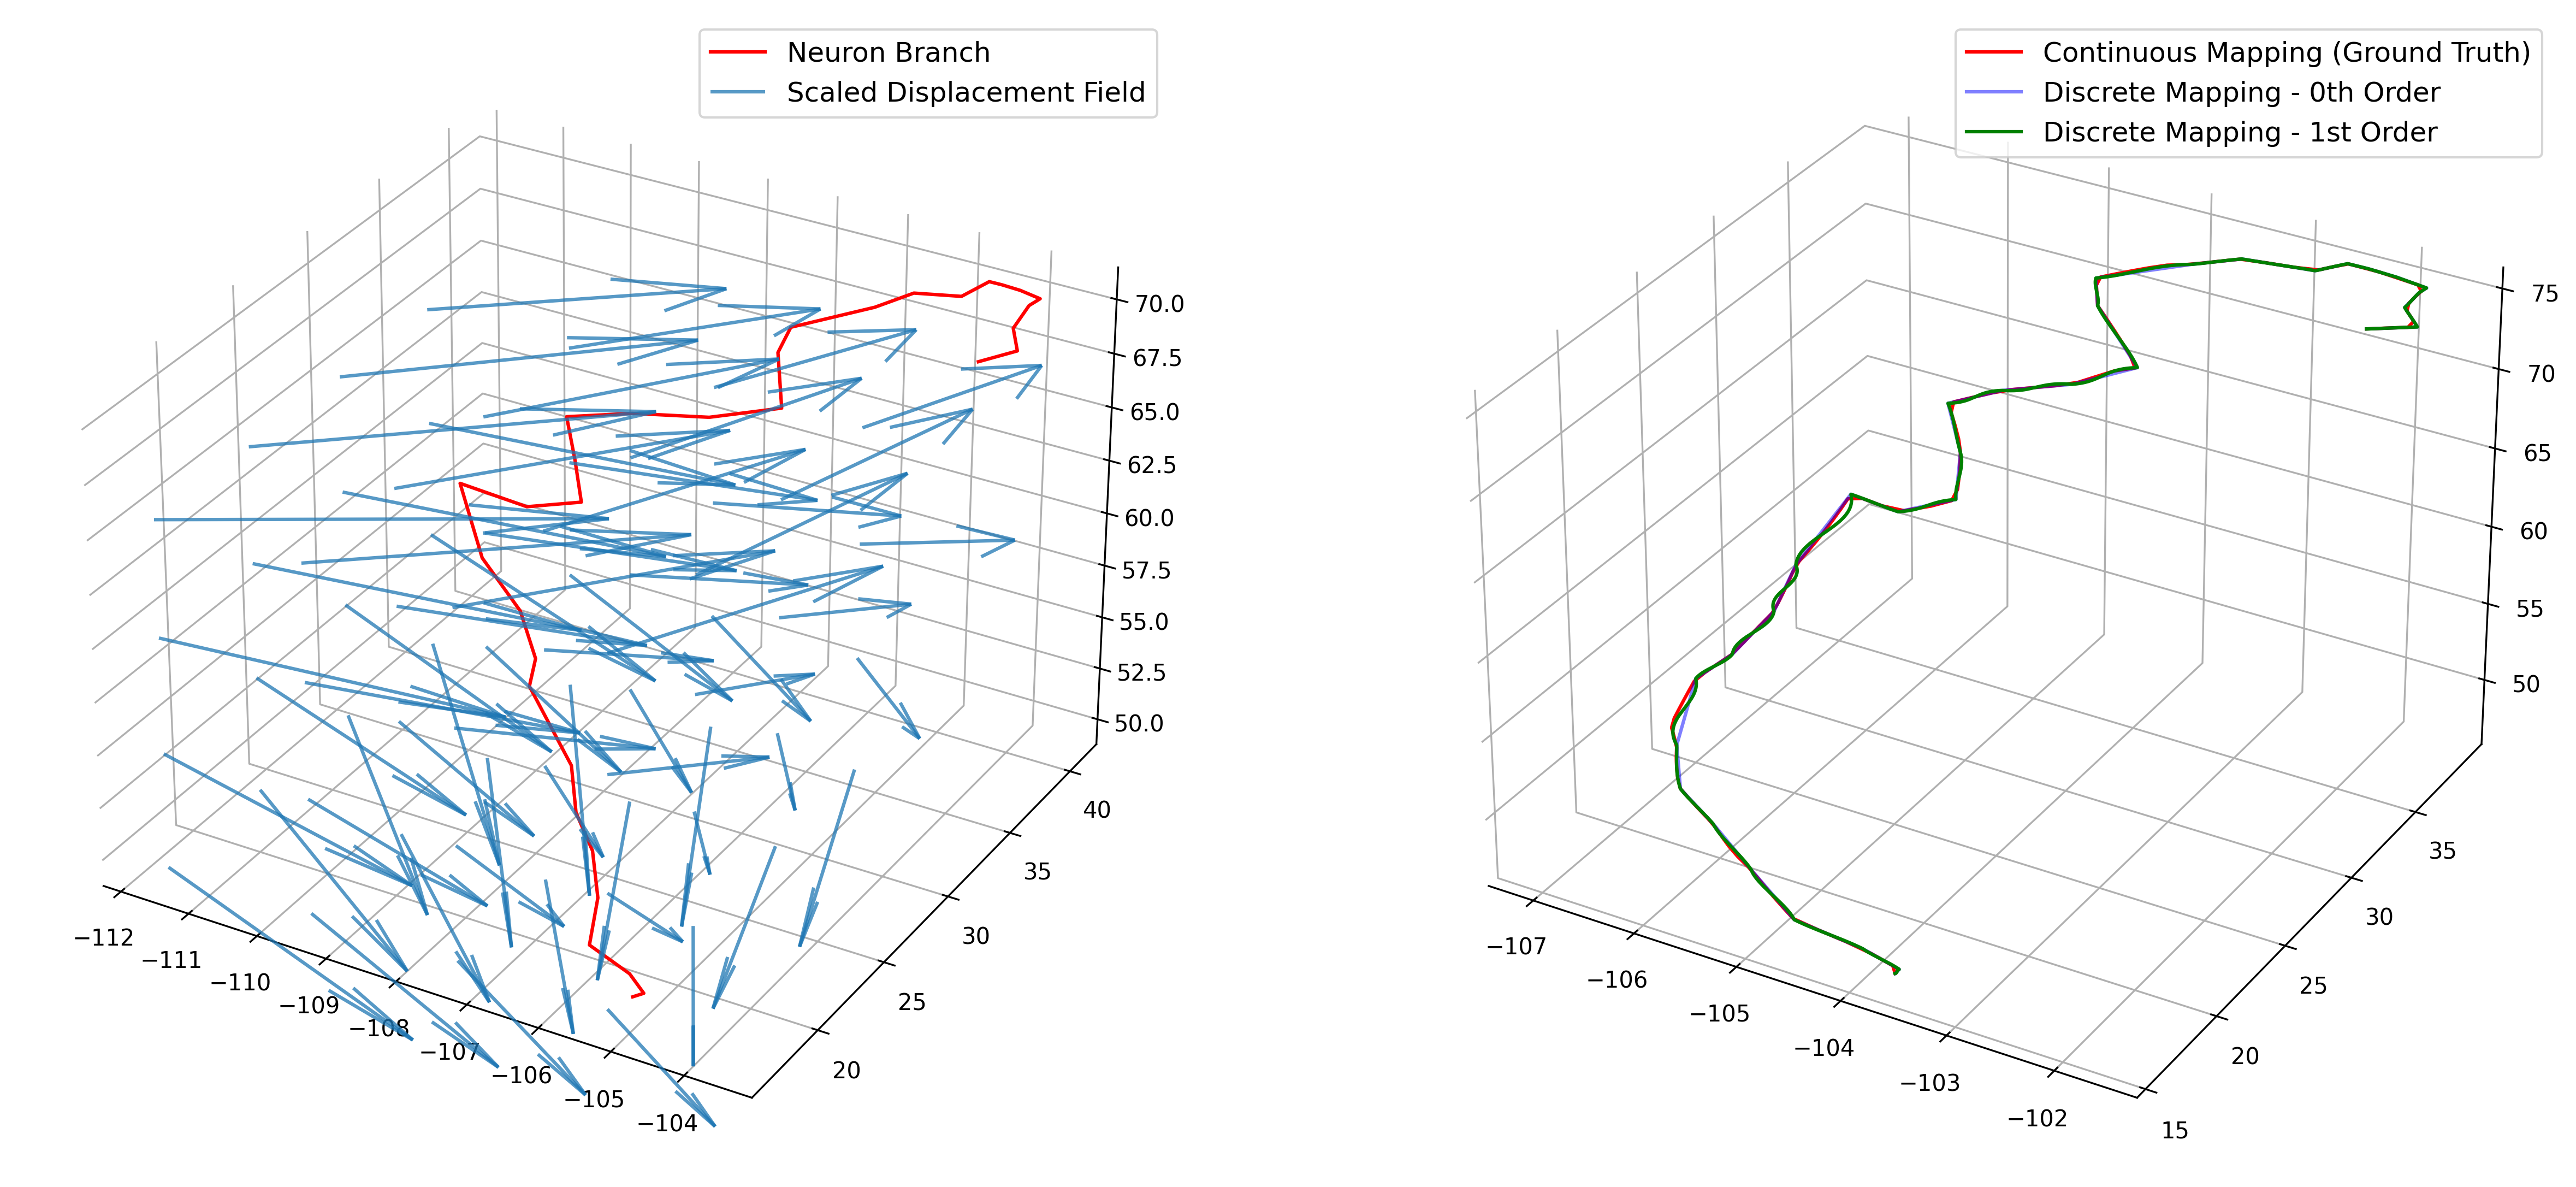

In [37]:
# 1,22; 4,179
neuron_id = 4
branch_id = 179

im_path = "precomputed://file://" + os.path.join(data_dir, "ch1_otsu_iso")
vol_im = CloudVolume(im_path)
shp = np.array(vol_im.shape)
res_im = np.array(vol_im.resolution) / 1000
origin_im = (shp[:3] - 1) * res_im / 2

axons_path = "precomputed://file://" + os.path.join(data_dir, "axons")
vol = CloudVolume(axons_path)
shp = np.array(vol.shape)
res_atlas = np.array(vol.resolution) / 1000
origin_atlas = (shp[:3] - 1) * res_atlas / 2

# get coords in proper cooordinates
skel = vol.skeleton.get(neuron_id)
coords = skel.vertices / 1000 - origin_im

# apply affine transform
coords = (coords - np.mean(coords, axis=0))/20

G = GeometricGraph()
for id, coord in enumerate(coords):
    G.add_node(id, loc=coord)
for edge in skel.edges:
    G.add_edge(edge[0], edge[1])

spline_tree = G.fit_spline_tree_invariant()

# Target space

fig = plt.figure(figsize=(20, 10), dpi=300)
ax = fig.add_subplot(1, 2, 1, projection="3d")

G_transformed = deepcopy(G)
G_transformed = transform_geometricgraph(G_transformed, ct, deriv_method="two-sided")
soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.spline_tree

for i, node in enumerate(tqdm(spline_tree.nodes, desc="Target space")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    # trace points only
    pts = splev(u, tck)
    if i == 0 or node == branch_id:
        label = "Neuron Branch"
    else:
        label = None
    ax.plot(pts[0], pts[1], pts[2], linestyle="-", label=label, color="red")
    derivs = splev(u, tck, der=1)

# Plot displacement field
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
zmin, zmax = ax.get_zlim()
xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T
new_coords = ct.evaluate(og_coords)

displacements = new_coords - og_coords
ax.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    displacements[:, 0],
    displacements[:, 1],
    displacements[:, 2],
    label="Scaled Displacement Field",
    alpha=0.75,
)  # length

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.legend(fontsize=12)


ax = fig.add_subplot(1, 2, 2, projection="3d")

spline = spline_tree.nodes[branch_id]["spline"]
u = spline[1]
tck = spline[0]
pts = splev(u, tck)
pts = np.stack(pts, axis=1)


# dense line points
tck_line, u_line = splprep(pts.T, k=1, s=0)
u_line = np.arange(u_line[0], u_line[-1] + 0.01, 0.01)
pts_line = splev(u_line, tck_line)
pts_line = np.stack(pts_line, axis=1)
trans_pts = ct.evaluate(pts_line)

label = "Continuous Mapping (Ground Truth)"
ax.plot(
    trans_pts[:, 0],
    trans_pts[:, 1],
    trans_pts[:, 2],
    linestyle="-",
    color="red",
    label=label,
)

# Transformed points
trans_pts = ct.evaluate(pts)
label = "Discrete Mapping - 0th Order"
ax.plot(
    trans_pts[:, 0],
    trans_pts[:, 1],
    trans_pts[:, 2],
    linestyle="-",
    label=label,
    color="blue",
    alpha=0.5,
)
derivs = splev(u, tck, der=1)
derivs = np.stack(derivs, axis=1)
trans_derivs = ct.D(pts, derivs)

# act on derivatives
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G_transformed.spline_tree

spline = spline_tree.nodes[branch_id]["spline"]
u = spline[1]
u = np.arange(u[0], u[-1] + 0.01, 0.01)
chspline = spline[0]
pts = chspline(u)

label = "Discrete Mapping - 1st Order"
ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], linestyle="-", label=label, color="green")

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
ax.legend(fontsize=12)

plt.show()

1st order mappings: 100%|██████████| 257/257 [00:00<00:00, 580.82it/s]


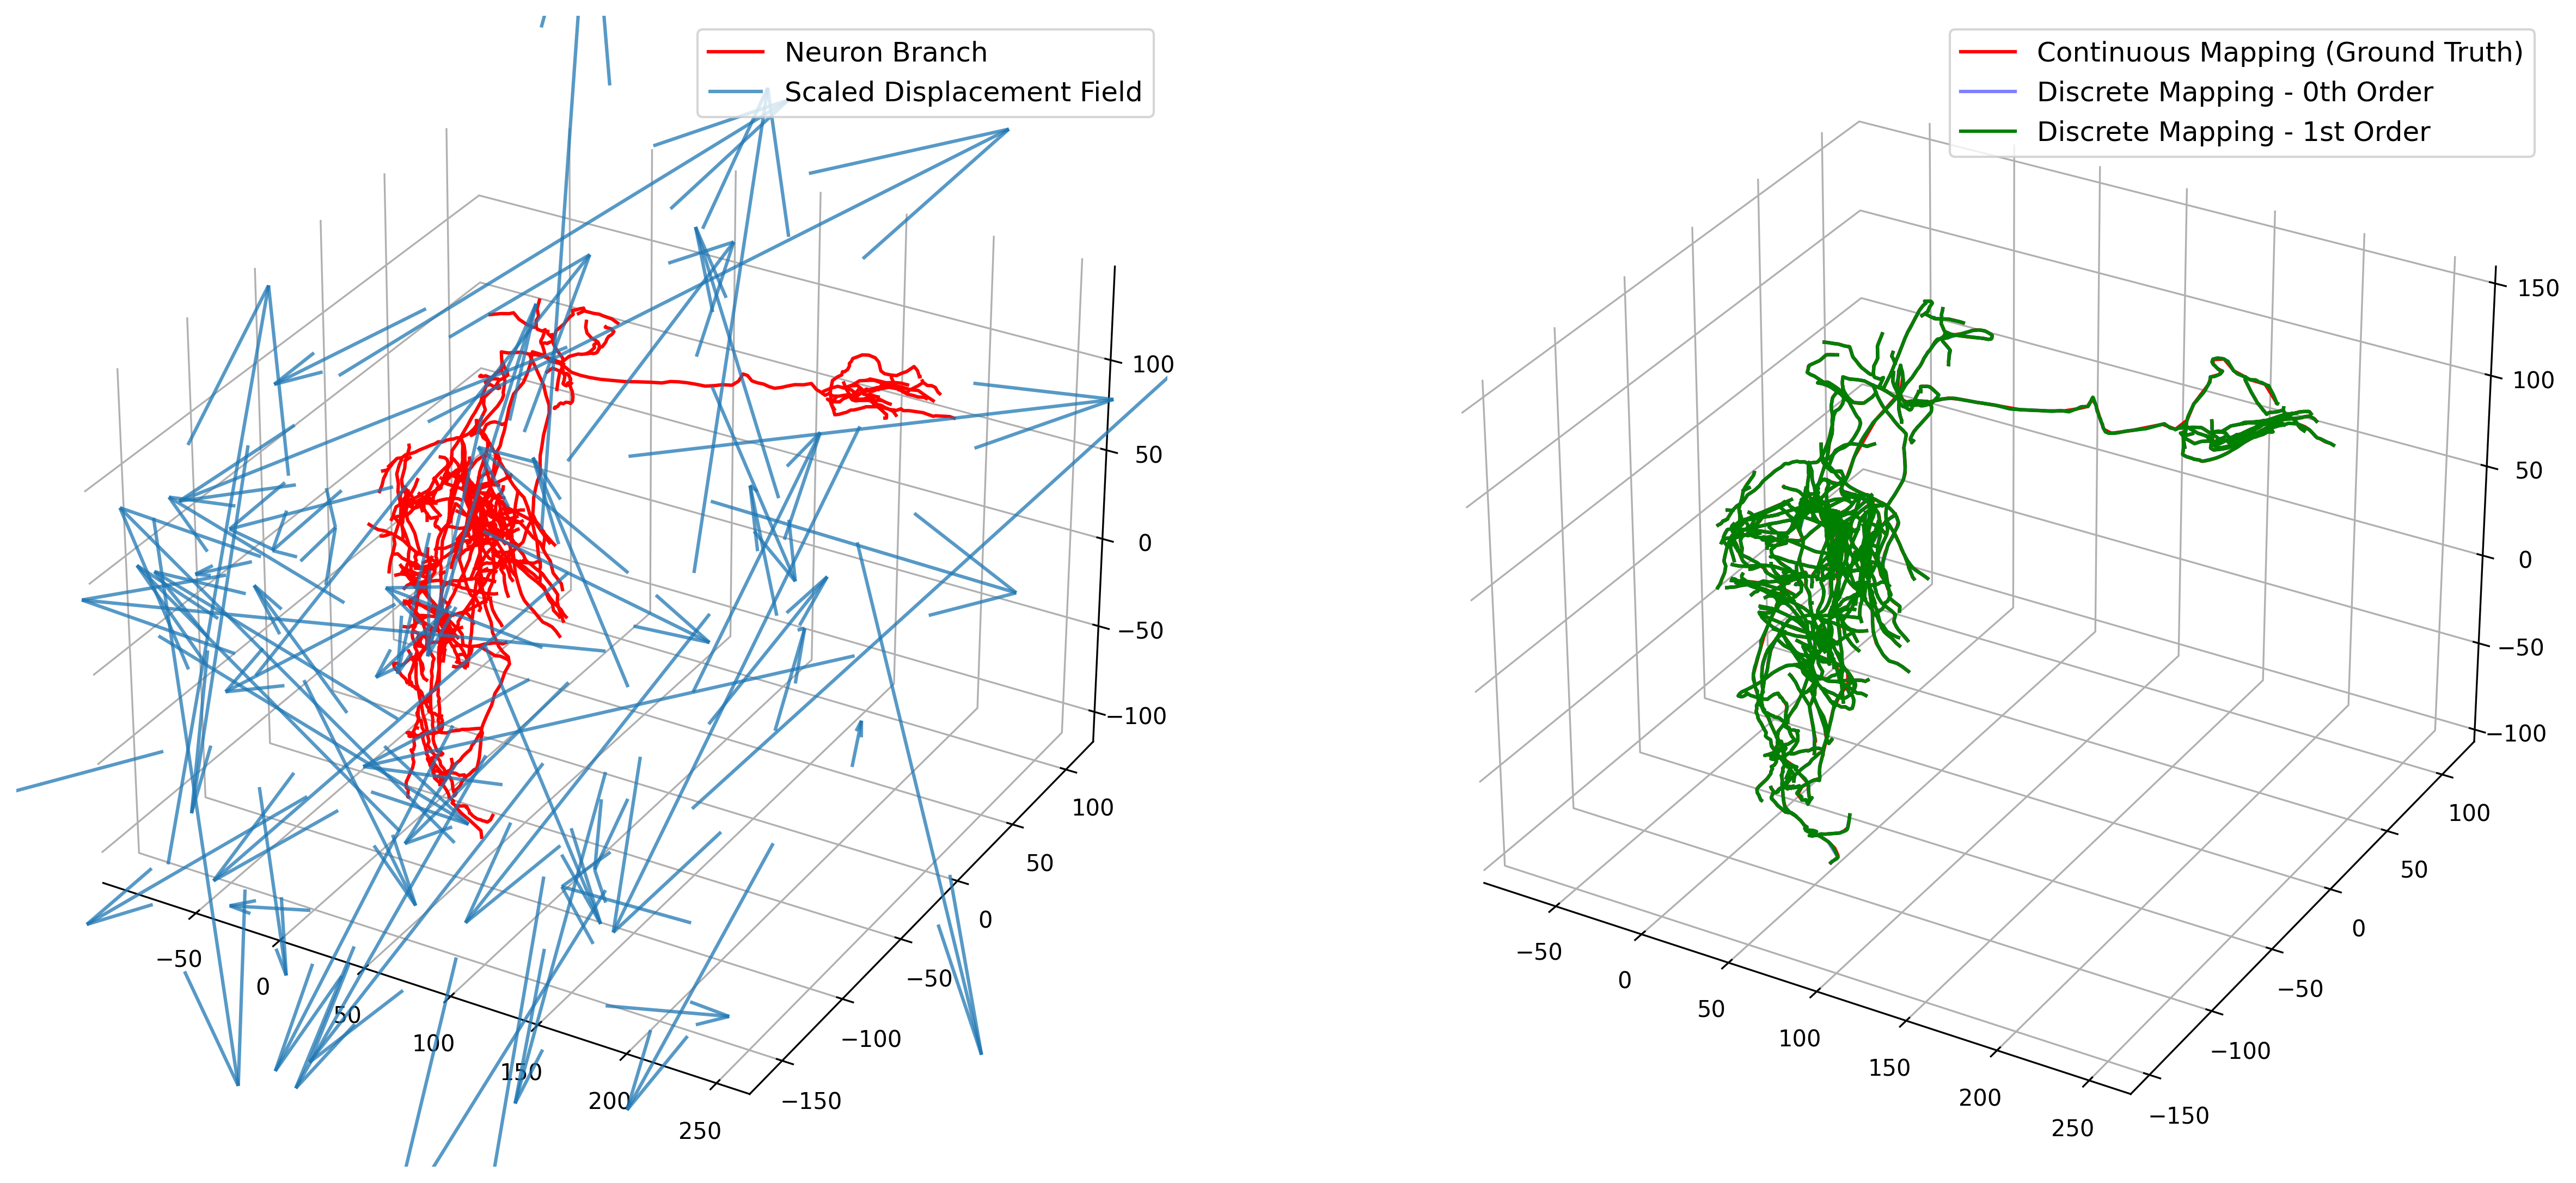

In [46]:
# 1,22; 4,179
neuron_id = 1
branch_id = -1

# get coords in proper cooordinates
skel = vol.skeleton.get(neuron_id)
coords = skel.vertices / 1000 - origin_im

# apply affine transform
coords = (coords - np.mean(coords, axis=0))/10

G = GeometricGraph()
for id, coord in enumerate(coords):
    G.add_node(id, loc=coord)
for edge in skel.edges:
    G.add_edge(edge[0], edge[1])

spline_tree = G.fit_spline_tree_invariant()

# Target space

fig = plt.figure(figsize=(20, 10), dpi=300)
ax = fig.add_subplot(1, 2, 1, projection="3d")

G_transformed = deepcopy(G)
G_transformed = transform_geometricgraph(G_transformed, ct, deriv_method="two-sided")
soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.spline_tree

for i, node in enumerate(tqdm(spline_tree.nodes, desc="Target space")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    # trace points only
    pts = splev(u, tck)
    if i == 0 or node == branch_id:
        label = "Neuron Branch"
    else:
        label = None
    ax.plot(pts[0], pts[1], pts[2], linestyle="-", label=label, color="red")
    derivs = splev(u, tck, der=1)

# Plot displacement field
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
zmin, zmax = ax.get_zlim()
xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T
new_coords = ct.evaluate(og_coords)

displacements = new_coords - og_coords
ax.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    displacements[:, 0],
    displacements[:, 1],
    displacements[:, 2],
    label="Scaled Displacement Field",
    alpha=0.75,
)  # length

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.legend(fontsize=12)


ax = fig.add_subplot(1, 2, 2, projection="3d")

for i, node in enumerate(tqdm(spline_tree.nodes, desc="0th order mappings")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)

    # dense line points
    tck_line, u_line = splprep(pts.T, k=1, s=0)
    u_line = np.arange(u_line[0], u_line[-1] + 0.01, 0.01)
    pts_line = splev(u_line, tck_line)
    pts_line = np.stack(pts_line, axis=1)
    trans_pts = ct.evaluate(pts_line)
    if i == 0 or node == branch_id:
        label = "Continuous Mapping (Ground Truth)"
    else:
        label = None
    ax.plot(
        trans_pts[:, 0],
        trans_pts[:, 1],
        trans_pts[:, 2],
        linestyle="-",
        color="red",
        label=label,
    )

    # Transformed points
    trans_pts = ct.evaluate(pts)
    if i == 0 or node == branch_id:
        label = "Discrete Mapping - 0th Order"
    else:
        label = None
    ax.plot(
        trans_pts[:, 0],
        trans_pts[:, 1],
        trans_pts[:, 2],
        linestyle="-",
        label=label,
        color="blue",
        alpha=0.5,
    )
    derivs = splev(u, tck, der=1)
    derivs = np.stack(derivs, axis=1)
    trans_derivs = ct.D(pts, derivs)

# act on derivatives
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G_transformed.spline_tree
for i, node in enumerate(tqdm(spline_tree.nodes, desc="1st order mappings")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1] + 0.01, 0.01)
    chspline = spline[0]
    pts = chspline(u)

    if i == 0 or node == branch_id:
        label = "Discrete Mapping - 1st Order"
    else:
        label = None
    ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], linestyle="-", label=label, color="green")

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
ax.legend(fontsize=12)

plt.show()

In [52]:
import pickle

with open("/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/ds_experiment/random-diffeo.pickle", 'wb') as f:
    pickle.dump(ct, f)

In [51]:
ct

<brainlit.map_neurons.map_neurons.Diffeomorphism_Transform object at 0x1387d3850>